In [1]:
from datetime import datetime
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.oso_db import execute_query
from scripts.eas_lists import create_eas_json
from visualizations.venn_diagram import venn3_diagram

In [2]:
START_DATE = '2019-01-01'
RPGF2_DATE = '2023-04-01'
END_DATE = '2023-10-01'

OP_RED = "#FF0420"
plt.rcParams['figure.dpi'] = 144
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'sans-serif']

In [3]:
path = "data/RPGF3/RPGF3_tagged_projects.csv"
project_data = pd.read_csv(path, index_col=0)

projects_to_exclude = [
    "Open Source Observer", # :)
    "Protocol Guild",       # has very high overlap with major Ethereum repos like go-ethereum
    "hildobby",             # can't take all the credit for Dune Spellbook :)
    "Optimistic Indexer",   # a repo owned by Polynomial Protocol with minimal GitHub activity
]

project_data.rename(columns={
    "Contributors Last 6 Months": "Unique GitHub contributors (last 6 months, all repos)",
    "Total Forks": "Fork count (most forked repo owned by the project)",
    "Total Stars": "Star count (most starred repo owned by the project)",
    "Downloads Last 6 Months": "NPM downloads (last 6 months, all packages)",   
    "Total Txn Fees (ETH)": "L2 sequencer fees (OP ETH)",    
    "Total Txns": "Transactions (on OP Mainnet)"
}, inplace=True)

project_data = project_data[~project_data['Project Name'].isin(projects_to_exclude)]
project_data.iloc[10].T

Project Name                                                                                      ACryptoS
Applicant Type                                                                                     PROJECT
Website                                                                          https://app.acryptos.com/
Bio                                                      Liquidity Manager & Optimizer - for V3 CL DEXs...
Payout Address                                                  0x5BD97307A40DfBFDBAEf4B3d997ADB816F2dadCC
OSO Slug                                                                                         acrypto-s
Category: Collective Governance                                                                          0
Category: Developer Ecosystem                                                                            0
Category: End User Experience and Adoption                                                               1
Category: OP Stack                   

In [4]:
ids_to_slugs = dict(project_data['OSO Slug'].dropna())
ids_to_names = dict(project_data['Project Name'])
slugs_to_ids = {v: k for k, v in ids_to_slugs.items()}
slugs = list(project_data['OSO Slug'].dropna().unique())

In [5]:
slugs_param = "','".join(slugs)

devs_query = execute_query(f"""
    WITH Devs AS (
        SELECT 
            p."slug" AS "slug",
            e."fromId" AS "fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            CASE WHEN COUNT(DISTINCT e."time") >= 10 THEN 1 ELSE 0 END AS "active_developer"
                FROM event e             
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" = 4 -- COMMIT CODE EVENTS ONLY
            AND p.slug IN ('{slugs_param}')
        GROUP BY
            p."slug",
            e."fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        SUM("active_developer")
    FROM Devs
    WHERE month >= '{START_DATE[:-3]}' AND month < '{END_DATE[:-3]}'
    GROUP BY slug;
""", col_names=True)

man_months = pd.DataFrame(devs_query[1:], columns=devs_query[0])
man_months['id'] = man_months['slug'].map(slugs_to_ids)
man_months.set_index('id', inplace=True)
man_months.rename(columns={'sum': 'Full-time developer months (cumulative)'}, inplace=True)
man_months.head(2)

,slug,Full-time developer months (cumulative)
id,,
0x2b4aeb64146ded169a426bde053b3f9e9e925ee740a58149d92812114af83de6,0x-splits,33
0x54763940f1803ecdd2adf48c1446268cdc3aa02e11090189cf91a78615c89d23,1w3,0


In [6]:
slugs_param = "','".join(slugs)

new_devs_query = execute_query(f"""
    WITH Devs AS (
        SELECT 
            p."slug" AS "slug",
            e."fromId" AS "fromId",
            MIN(e."time") AS "first_contribution"
        FROM event e             
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId"IN (2,4,18)
            AND p.slug IN ('{slugs_param}')
        GROUP BY
            p."slug",
            e."fromId"
    )
    SELECT 
        slug,
        COUNT(DISTINCT "first_contribution") AS "new_contributors"
    FROM Devs
    WHERE "first_contribution" >= '{RPGF2_DATE}'
    GROUP BY slug;
""", col_names=True)

new_devs = pd.DataFrame(new_devs_query[1:], columns=new_devs_query[0])
new_devs['id'] = new_devs['slug'].map(slugs_to_ids)
new_devs.set_index('id', inplace=True)
new_devs.rename(columns={'new_contributors': 'New GitHub contributors (last 6 months)'}, inplace=True)
new_devs.head(2)

,slug,New GitHub contributors (last 6 months)
id,,
0x2b4aeb64146ded169a426bde053b3f9e9e925ee740a58149d92812114af83de6,0x-splits,13
0x54763940f1803ecdd2adf48c1446268cdc3aa02e11090189cf91a78615c89d23,1w3,1


In [7]:
slugs_param = "','".join(slugs + ['op', 'protocol-guild', 'spellbook-duneanalytics'])

stars_query = execute_query(f"""
    SELECT 
        p."slug" AS "slug",
        e."fromId" AS "fromId",
        SUM(CASE WHEN e."typeId" = 21 THEN e."amount" END) AS "stars",
        SUM(CASE WHEN e."typeId" = 4 THEN e."amount" END) AS "commits"
    FROM event e             
    JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
    JOIN project p ON paa."projectId" = p.id         
    WHERE
        e."typeId" IN (4,21)
        AND p.slug IN ('{slugs_param}')
    GROUP BY
        p."slug",
        e."fromId";
""", col_names=True)

stars = pd.DataFrame(stars_query[1:], columns=stars_query[0])
stars.head(2)

,slug,fromId,stars,commits
0,0x-splits,33666,1.0,NaN
1,0x-splits,34034,2.0,NaN


In [8]:
self_stars = list(stars[['stars', 'commits']].dropna().index)
committed_users = stars[stars['commits']>0]['fromId'].unique()
filtered_stars = stars[(~ stars.index.isin(self_stars)) & (stars['fromId'].isin(committed_users))]
committed_stars = filtered_stars.groupby('slug')['fromId'].nunique()
committed_stars = committed_stars.drop(['op', 'protocol-guild', 'spellbook-duneanalytics'])
committed_stars.name = "Star count (from developers in the OP community only)"
committed_stars = committed_stars.reset_index()
committed_stars['id'] = committed_stars['slug'].map(slugs_to_ids)
committed_stars.set_index('id', inplace=True)
committed_stars.head(2)

,slug,Star count (from developers in the OP community only)
id,,
0x2b4aeb64146ded169a426bde053b3f9e9e925ee740a58149d92812114af83de6,0x-splits,81
0x54763940f1803ecdd2adf48c1446268cdc3aa02e11090189cf91a78615c89d23,1w3,2


In [9]:
all_users_query = execute_query(f"""
    SELECT 
        p."slug" AS "slug",
        e."fromId" AS "user",
        SUM(e."amount") as "txns",
        MIN(e."time") AS "first_event",
        MIN(e."time") AS "last_event"
    FROM event e
    JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
    JOIN project p ON paa."projectId" = p.id         
    WHERE
        e."typeId" = 25 -- TXN EVENTS ONLY
    GROUP BY
        p."slug",
        e."fromId"
""", col_names=True)

df_all_users = pd.DataFrame(all_users_query[1:], columns=all_users_query[0])
df_all_users['first_event'] = df_all_users['first_event'].apply(lambda x: x.strftime('%Y-%m'))
df_all_users['last_event'] = df_all_users['last_event'].apply(lambda x: x.strftime('%Y-%m'))
df_all_users.head(2)

,slug,user,txns,first_event,last_event
0,0x-splits,30358.0,4.0,2023-07,2023-07
1,0x-splits,507659.0,2.0,2022-10,2022-10


(<Figure size 1440x1440 with 1 Axes>, <Axes: >)

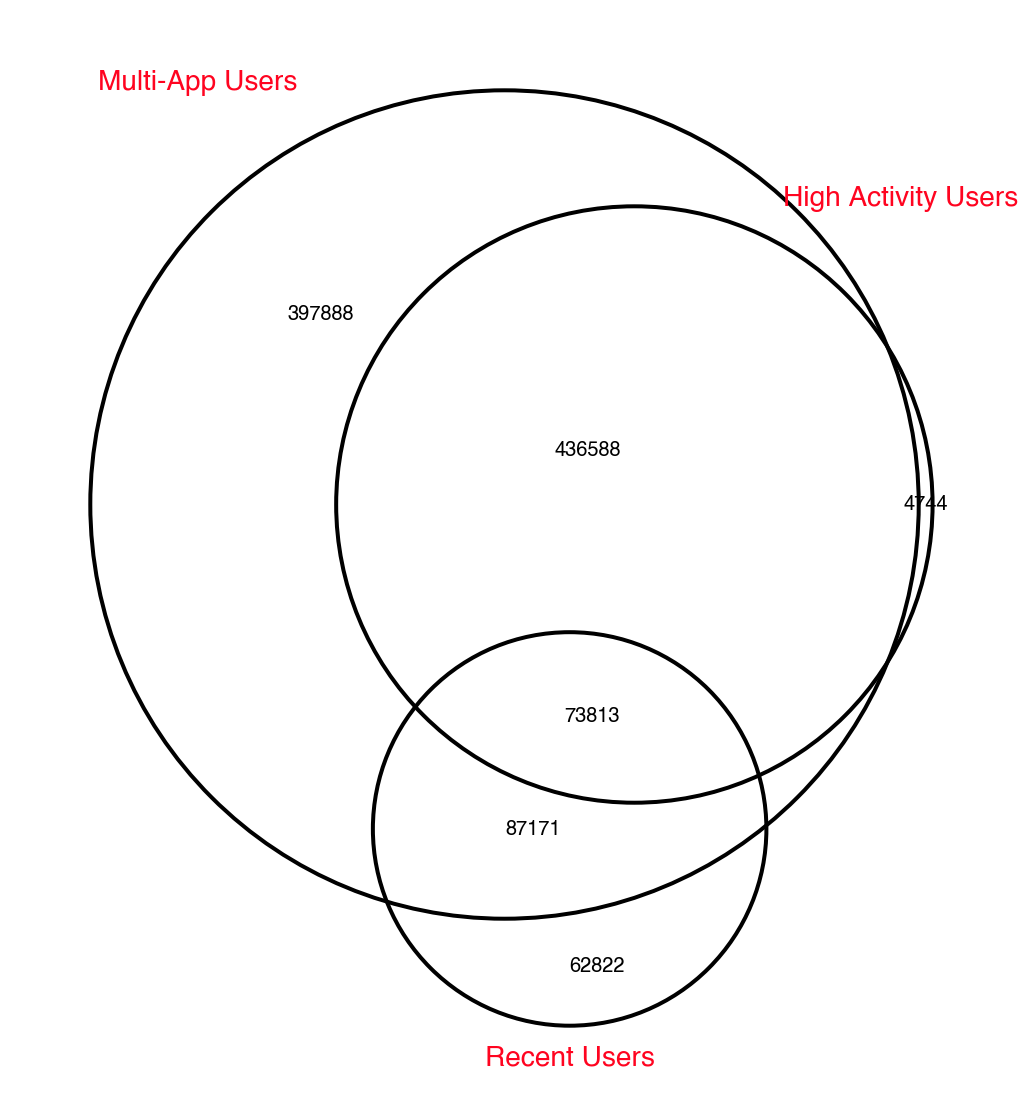

In [10]:
rpgf3_app_users = set(df_all_users[df_all_users['slug'].isin(slugs)]['user'].unique())

recent_users = set(df_all_users[df_all_users['last_event'] >= '2023-08'].index).intersection(rpgf3_app_users)

txns_per_user = df_all_users.groupby('user')['txns'].sum()
most_active_users = set(txns_per_user[txns_per_user>=30].index).intersection(rpgf3_app_users)

apps_per_user = df_all_users.groupby('user')['slug'].nunique()
multi_app_users = set(apps_per_user[apps_per_user>=3].index).intersection(rpgf3_app_users)

venn3_diagram(
    [multi_app_users, most_active_users, recent_users], 
    ["Multi-App Users", "High Activity Users", "Recent Users"],
    labelcolor=OP_RED,
    fontsize=12
)

In [11]:
hvaus = recent_users.intersection(most_active_users).intersection(multi_app_users)
hvaus_by_app = (df_all_users[
    (df_all_users['user'].isin(hvaus)) & (df_all_users['slug'].isin(slugs))
].groupby('slug')['user'].nunique())
hvaus_by_app.name = "High value users (on OP Mainnet)"
hvaus_by_app = pd.DataFrame(hvaus_by_app).reset_index()
hvaus_by_app['id'] = hvaus_by_app['slug'].map(slugs_to_ids)
hvaus_by_app.set_index('id', inplace=True)
hvaus_by_app.head(2)

,slug,High value users (on OP Mainnet)
id,,
0x2b4aeb64146ded169a426bde053b3f9e9e925ee740a58149d92812114af83de6,0x-splits,6
0xc69423093777bdb9ea96d3047694d4de113cc4722d9832e09bb717e570ddb941,across,4970


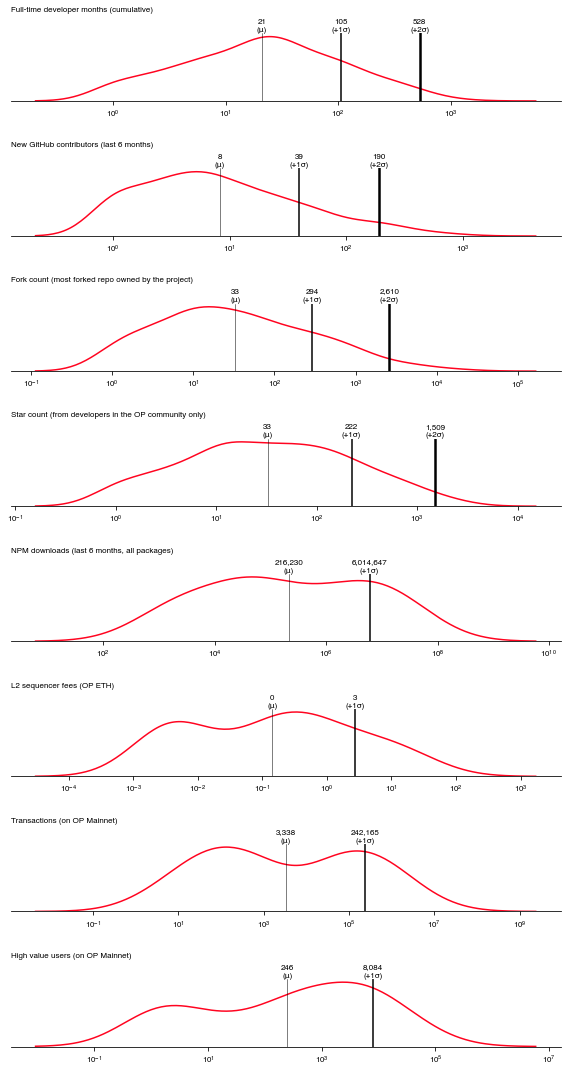

In [12]:
consolidated_df = project_data.join(
    man_months['Full-time developer months (cumulative)']
).join(
    new_devs['New GitHub contributors (last 6 months)']
).join(
    hvaus_by_app['High value users (on OP Mainnet)']
).join(
    committed_stars['Star count (from developers in the OP community only)']
)
code_vectors = [
    "Full-time developer months (cumulative)",
    "New GitHub contributors (last 6 months)",
    "Fork count (most forked repo owned by the project)",
    "Star count (from developers in the OP community only)",
    "NPM downloads (last 6 months, all packages)"
]
onchain_vectors = [
    "L2 sequencer fees (OP ETH)",    
    "Transactions (on OP Mainnet)",
    "High value users (on OP Mainnet)"    
]
vectors_list = code_vectors + onchain_vectors

disambiguations = {
    "gitcoin": {
        "code": "0x859d7ec1d7414662658b753da4559bfa6d091483fd0084b673a374e1c3cabf05",
        "contracts": "0x60085a98f5c48d97a28d7b45d193f9a734d1704e257df91827459b09565e0e47"
    },
    "rainbow": {
        "code": "0xe9140c31f3a448f0f52124b3f9782f7947d698a686ceb20f77f60366670f3f8e",
        "contracts": "0xb1af1a67d6a94f233303d850c607aa1e26365237ab1376864a81d636ec0ebe0a"
    }
}
for slug, mappings in disambiguations.items():
    code_id = mappings["code"]
    contract_id = mappings["contracts"]
    consolidated_df.loc[code_id, code_vectors] = consolidated_df.loc[[code_id, contract_id], code_vectors].sum(axis=0)
    consolidated_df.loc[contract_id, code_vectors] = np.nan
    consolidated_df.loc[contract_id, onchain_vectors] = consolidated_df.loc[[code_id, contract_id], onchain_vectors].sum(axis=0)
    consolidated_df.loc[code_id, onchain_vectors] = np.nan
    

fig, axes = plt.subplots(figsize=(8,15), ncols=1, nrows=8)

def impact_vector(col_name, ax):
    
    series = consolidated_df[col_name].copy()
    vector = series[series>0.001].dropna()        
    logvector = np.log(vector).sort_values(ascending=False)
    mu = logvector.mean()
    sigma = logvector.std()
    
    def scorer(x):
        p = (x-mu)/sigma 
        if  p >= 2:
            return 1.5
        elif p >= 1:
            return 1.0
        elif p >= 0.5:
            return 0.25
        else:
            return 0
        
    scores = logvector.apply(scorer)    
    scores.name = f"Vector: {col_name}"
    
    if not ax:
        fig, ax = plt.subplots(figsize=(8,2))
    sns.kdeplot(vector, ax=ax, color=OP_RED, log_scale=True)
    
    _, ymax = ax.get_ylim()
    xmin, xmax = np.log10(ax.get_xlim())
    
    mean = np.exp(mu)
    ax.axvline(x=mean, color='black', lw=.5)
    ax.text(x=mean, y=ymax, s=f"{mean:,.0f}\n(μ)", ha='center', va='bottom', fontsize=8)
    
    sig1 = np.exp(mu + sigma)
    ax.axvline(x=sig1, color='black', lw=1.5)
    ax.text(x=sig1, y=ymax, s=f"{sig1:,.0f}\n(+1σ)", ha='center', va='bottom', fontsize=8)
    
    sig2 = np.exp(mu + sigma*2)
    if len(vector[vector >= sig2]):
        ax.axvline(x=sig2, color='black', lw=2.5)
        ax.text(x=sig2, y=ymax, s=f"{sig2:,.0f}\n(+2σ)", ha='center', va='bottom', fontsize=8)
    
    ax.minorticks_off()
    ax.set_xlabel("")
    ax.set_yticks([])
    ax.set_ylabel("")
    
    ax.set_title(col_name+"\n\n", loc='left', fontsize=8, fontweight='bold')
    return scores

dfs = [impact_vector(v, axes[i]) for i,v in enumerate(vectors_list)]
vectors = pd.concat(dfs, axis=1)
vectors['Score'] = vectors.sum(axis=1)
df = consolidated_df[['Project Name']].join(vectors).fillna(0)
df = df[df['Score'] > 0]

fig.tight_layout()
fig.subplots_adjust(hspace=1)

9
0
Socket , Galxe, Synapse Labs, Clique, Clipper, Kwenta, Sushi, Velodrome, RabbitHole


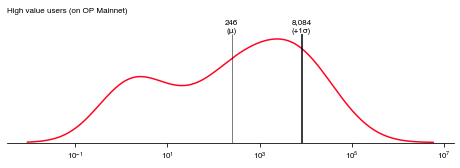

In [13]:
v = vectors_list[7]
impact_vector(v, None)
scores = df[f"Vector: {v}"].sort_values(ascending=False)
projects_list = list(scores[scores>=1].index)
projects_sig2 = list(scores[scores>=2].index)
project_names = ", ".join([
    f"{ids_to_names[p]}**" if p in projects_sig2 else ids_to_names[p]
    for p in projects_list
])
print(len(projects_list))
print(len(projects_sig2))
print(project_names)

In [14]:
df.sort_values(by='Score', ascending=False, inplace=True)

print(df['Score'].sum())

df

290.25


,Project Name,Vector: Full-time developer months (cumulative),Vector: New GitHub contributors (last 6 months),Vector: Fork count (most forked repo owned by the project),Vector: Star count (from developers in the OP community only),"Vector: NPM downloads (last 6 months, all packages)",Vector: L2 sequencer fees (OP ETH),Vector: Transactions (on OP Mainnet),Vector: High value users (on OP Mainnet),Score
Project ID,,,,,,,,,,
0x6ae2bf87fcbddb4d715add72ea987fcb9537ec19e3f859befeebeed533144e73,Synthetix,1.50,1.00,1.00,1.00,0.0,1.00,1.00,0.25,6.75
0x912e6971c43c3a46dbb82d1358af205530663ef01c2fb0691d843a9f72293689,OpenZeppelin Contracts,1.00,1.50,1.50,1.50,1.0,0.00,0.00,0.00,6.50
0xda04cebe79ec8547116a948edfbdb87e48dcb0543b29b7276df53df579170f74,DefiLlama,1.00,1.50,1.50,1.50,0.0,0.00,0.25,0.25,6.00
0x4ee85a3d39e87cfd1f59d5067668bcacfaf111b74bbd3d1fcbe6da166395f372,IPFS,1.50,1.50,1.50,1.50,0.0,0.00,0.00,0.00,6.00
0x176d93beb29316e51b21e42cc1d49ef0867b37bda258b06ba410a3043fee7df5,Sushi,1.00,0.25,1.00,1.00,0.0,0.25,1.00,1.00,5.50
...,...,...,...,...,...,...,...,...,...,...
0x013249f25537a8abdd06d367538d0eab0c9e5e8e36dde210abe1e7da8dd89c9e,LearnWeb3,0.00,0.00,0.00,0.25,0.0,0.00,0.00,0.00,0.25
0xaee5d6c20a44b769b67767b8e691476d87b0b644784f635664c3f133c63e822b,Keccak hashing,0.00,0.00,0.25,0.00,0.0,0.00,0.00,0.00,0.25
0x2baa369e4449595c51759fa9a5b71e3e016b108b6baac6a0b815874a898eade5,Impersonator,0.00,0.00,0.00,0.25,0.0,0.00,0.00,0.00,0.25


In [15]:
eas_metadata = create_eas_json(
    allocation_dict = dict(df['Score'].sort_values(ascending=False) * 100000),
    list_name="This list measures progress against eight impact vectors that are important to the growth and adoption of Optimism: developers, new contributor growth, forks, stars from within the OP community, NPM downloads, sequencer fees, onchain transactions, and 'high value' onchain users. This list is powered by Open Source Observer.",
    list_link="https://cerv1.notion.site/Impact-Vectors-cce18aac941247cc9ed44dc20521d4c2?pvs=4",
    list_descr="See the link for a full write-up of the methodology, including links to source code. For each vector, projects’ contributions are plotted on a log-normal distribution. Projects are awarded OP tokens based on the standard deviation from the mean: 2+ = 150K OP, 1-2 = 100K OP, 0.5-1 = 25K OP. Note: lists generated by the OSO team do not include OSO in them in order to comply with voting rules, so please consider adding our project to your ballot separately. Always remember to DYOR before voting: project data is never complete and never tells the full story!",
    list_categories=["OP Stack"]
)

In [16]:
json_path  = "data/RPGF3/ImpactVectors.json"
with open(json_path, "w") as f:
    json.dump(eas_metadata, f, indent=4)

In [17]:
project_data[['Project Name']].join(df['Score']).join(consolidated_df[vectors_list]).to_csv("data/RPGF3/ImpactVectors.csv")